---
title: Simple TEM Imaging and Diffraction
authors: [Toma Susi]
date: 2024/09/06
---

### Imports

In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

abtem.config.set({"visualize.cmap": "viridis"})
abtem.config.set({"visualize.continuous_update": True})
abtem.config.set({"visualize.autoscale": True})
#abtem.config.set({"visualize.reciprocal_space_units": "mrad"})
abtem.config.set({"device": "cpu"})
abtem.config.set({"fft": "fftw"});

from matplotlib.patches import Circle
from ipywidgets import HBox, VBox, widgets, interact, Dropdown, Label, Layout

### Atomic Model

To start running image simulations, we need an atomic model. Below we create a Potential representing gold with a lattice constant of 4.08 Å in the <100> zone axis and use a PlaneWave as the initial wave function.

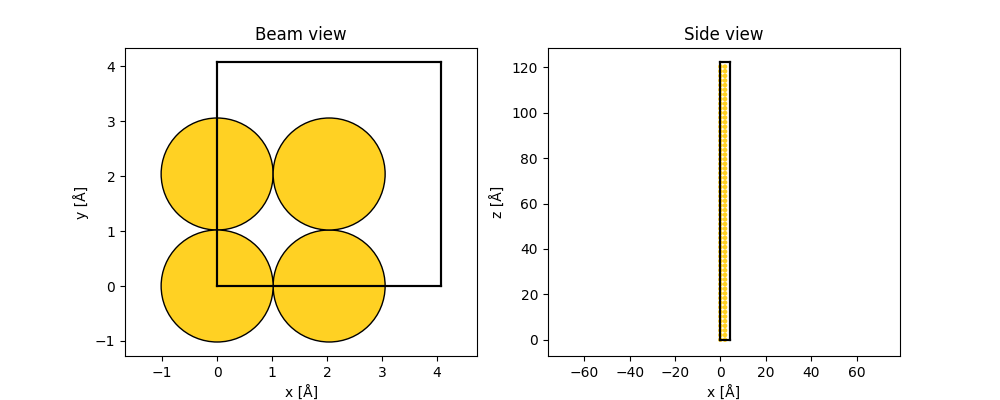

In [133]:
unit_cell = ase.build.bulk("Au", cubic=True)

atoms = unit_cell * (1, 1, 30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view")
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", linewidth=0);

### abTEM potential

We use the indepedent atom model (IAM) to create the electrostatic potential of the sample. In this standard approximation, the potential is a superposition of parameterized isolated atomic potentials. More information on potentials in *ab*TEM may be found online [walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/potentials.html).

The default parametrization is the one by Lobato, though also Kirkland and Peng are available. For most practical purposes, the differences are minor.

To define a `Potential`, we need to provide an ASE `Atoms` object, a sampling rate (or pixel size) in $x$ and $y$, and a slice thickness in the $z$-direction (the propagation direction).

The multislice algorithm is only accurate in the limit of good (small) sampling rate and thin slices, but improving these parameters also increases computational cost. A sensible value for the sampling is between $\mathrm{0.05} \ \mathrm{Å}$ and $0.02 \ \mathrm{Å}$, and the slice thickness is typically between $1.0 \ \mathrm{Å}$ and $0.025 \ \mathrm{Å}$, though the value of $2.0 \ \mathrm{Å}$ used here may suffice.

Both should be treated as convergence parameters, which need to be small enough so that the simulated signal does not depend on the exact values.

In [135]:
potential = abtem.Potential(atoms, slice_thickness=4.08 / 2, sampling=0.04)

*ab*TEM has some features for showing the simulation objects interactively. Here, we convert the potential slice to a stack of images and show the result with `interact=True`, allowing us to scroll through slices. 

### Plane Wave

To describe a parallel illumination TEM experiment, we create a `PlaneWave` with an energy of $200 \ \mathrm{keV}$.

In [136]:
plane_wave = abtem.PlaneWave(energy=200e3)

We will show an example of how to simulate a thickness series. To do this, we have to recreate our potential with the `exit_planes` argument. We set it to one to specify that we want an output exit wave for every single slice.-

In [138]:
potential = abtem.Potential(atoms, slice_thickness=4.08 / 2, sampling=0.04, exit_planes=2)

__Note__: We did not define the wave function sampling, hence it will match the potential. We do not need to match the sampling of the wavefunction to an experimental pixel size, as we can always interpolate the final result.

We run the mulislice algorithm. 

In [140]:
exit_wave = plane_wave.multislice(potential).compute()

[########################################] | 100% Completed | 207.78 ms


We show the exit wave intensity - note that we omit the first slice that does not contain atoms and whose exit waves thus simply show numerical noise.

We now have to specify the aberrations and aperture of the objective lens, which are done via the contrast transfer function (CTF).

We create a compatible `CTF` for electrons of the same energy as the plane wave of $150 \ \mathrm{keV}$. The spherical aberration will be set to $-20~\mu \mathrm{m}$ (remember that *ab*TEM uses units of $\mathrm{Å}$) and the defocus is set to the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy).

In [141]:
Cs = -20e-6 * 1e10

ctf = abtem.CTF(Cs=Cs, energy=200e3)

ctf.scherzer_defocus

ctf.defocus = ctf.scherzer_defocus
ctf.semiangle_cutoff = ctf.crossover_angle
ctf.focal_spread = 30
ctf.angular_spread = 1

We apply the `CTF` to the exit wave to get the wave at the detector plane.

In [142]:
image = exit_wave.apply_ctf(ctf).intensity().compute()

In [148]:
%matplotlib ipympl

with plt.ioff():
    dpi = 72
    fig, axs = plt.subplots(1,3, figsize=(675/dpi, 400/dpi), dpi=dpi)

pots = potential.to_images()[0].show(ax=axs[0])
wavs = exit_wave[1:][0].show(ax=axs[1])
imgs = image[1:][0].show(ax=axs[2])

#pots = axs[0].imshow(potential[0].array[0])
#wavs = axs[1].imshow(exit_wave[1:][0].intensity().array)
#imgs = axs[2].imshow(image[1:][0].array)

axs[0].set_title('Potential')
axs[1].set_title('Exit wave')
axs[2].set_title('Image')

axs[1].set_yticks([])
axs[2].set_yticks([])
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.tight_layout()  

# interact
def update_images(plane):    
    axs[0].cla()
    axs[1].cla()
    axs[2].cla()

    pots._artists[0,0].set_data(potential[plane].array)
    wavs._artists[0,0].set_data(exit_wave[1:][plane].array)
    imgs._artists[0,0].set_data(image[1:][plane].array)

    #pots.set_data(potential[plane].array[0])
    #wavs.set_data(exit_wave[1:][plane].intensity().array)
    #imgs.set_data(image[1:][plane].array)

    fig.canvas.draw_idle()
    return None

style = {
    'description_width': 'initial',
}

layout = Layout(width='250px',height='30px')

plane = widgets.IntSlider(
    value = 0, max = len(potential),
    step = 2,
    description = "Slice",
    style = style,
    layout = layout,
)

widgets.interactive_output(
    update_images, 
    {
        'Slice':plane,
    },
)

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '400px'
fig.canvas.toolbar_position = 'bottom'

widget = widgets.VBox(
    [
        fig.canvas,
            HBox(
                [plane]
            )
    ],
)

[########################################] | 100% Completed | 105.14 ms


In [149]:
#| label: app:tem_Au_potential_wave_image

display(widget);

Equally, we can calculate the diffraction pattern as a function of depth through the specimen, showing the redistribution of intensity to different diffraction orders.

In [152]:
diffraction = exit_wave.diffraction_patterns().compute()

In [206]:
diff = diffraction[1:].block_direct().show(cbar=True, interact=True)

ImageGUI(children=(VBox(children=(SelectionSlider(description='z [Å]', options=('4.080', '8.160', '12.240', '1…

In [204]:
indexed_spots = diffraction[1:].crop(120).index_diffraction_spots(cell=unit_cell)

visualization = (
    indexed_spots.block_direct()
    .crop(120)
    .show(
        scale=0.2,
        cbar=True,
        annotation_kwargs={"threshold": 0.001, "fontsize": 7},
        figsize=(8, 8),
        interact=True
        )
)

ScatterGUI(children=(VBox(children=(SelectionSlider(description='z [Å]', options=('4.080', '8.160', '12.240', …

In [202]:
%matplotlib ipympl

with plt.ioff():
    dpi = 72
    fig, axs = plt.subplots(1,2, figsize=(675/dpi, 275/dpi), dpi=dpi)

diff = diffraction[1:].block_direct().crop(50).show(ax=axs[0])#, cbar=True)
spts = indexed_spots[1:].block_direct().crop(50).show(ax=axs[1],
        scale=0.2,
        cbar=True,
        annotation_kwargs={"threshold": 0.001, "fontsize": 7},
        figsize=(8, 8),
    )


#pots = axs[0].imshow(potential[0].array[0])
#wavs = axs[1].imshow(exit_wave[1:][0].intensity().array)

axs[0].set_title('Diffraction pattern')
axs[1].set_title('Indexed reflections')

#axs[1].set_yticks([])
axs[1].set_ylabel("")

plt.tight_layout()  

# interact
def update_images(plane):    
    axs[0].cla()
    axs[1].cla()

    diff = diffraction[1:].block_direct().crop(35).show(ax=axs[0], cbar=True)
    spts = indexed_spots.block_direct().crop(120).show(ax=axs[1], cbar=True)

    fig.canvas.draw_idle()
    return None

style = {
    'description_width': 'initial',
}

layout = Layout(width='250px',height='30px')

plane = widgets.IntSlider(
    value = 0, max = len(potential),
    step = 1,
    description = "Slice",
    style = style,
    layout = layout,
)

widgets.interactive_output(
    update_images, 
    {
        'Slice':plane,
    },
)

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '275px'
fig.canvas.toolbar_position = 'bottom'

widget2 = widgets.VBox(
    [
        fig.canvas,
            HBox(
                [plane]
            )
    ],
)

In [203]:
#| label: app:tem_Au_diffraction

display(widget2);